# Preprocessing

## JSON $\rightarrow$ Pandas
Turning metadatas json into useful and readable pandas dataframes

in order to make this script work you need to have the dataset in the working wolder such as:
```
>> fds-2022-final-project
    >> ...
    >> og_dataset
        >> slices.json
        >> splits
            >> train/
            >> dev/
            >> test/
```

In [68]:
import json
import os
import numpy as np
import pandas as pd

metadata_file = 'og_dataset/slices.geojson'
normalization_file = 'og_dataset/stats_train.json'
train_folder = 'og_dataset/splits/train/'
dev_folder   = 'og_dataset/splits/dev/'
test_folder  = 'og_dataset/splits/test/'

We first import the json file, and take only the information regarding all the patches, while adding to it the center of the longitude and latitude of the patch

In [67]:
with open(metadata_file) as f:
    d = json.load(f)
patches = d['features']
patches = [{
    **p['properties'], 
     'lng':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[0],
     'lat':np.mean(p['geometry']['coordinates'][0][:-1], axis=0)[1]
    } for p in patches]
patches[:2]

[{'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_000.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_000.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 77.38898468017578,
  'lng': 333795.9649122807,
  'lat': 3572176.06391926},
 {'img_source': '/datadrive/glaciers/unique_tiles/LE07_149037_20041024.tif',
  'mask_source': '/datadrive/glaciers/processed/masks/mask_00.npy',
  'img_slice': '/datadrive/glaciers/processed/slices/slice_0_img_001.npy',
  'mask_slice': '/datadrive/glaciers/processed/slices/slice_0_mask_001.npy',
  'mask_mean_0': 0.0,
  'mask_mean_1': 0.0,
  'mask_mean_2': 0.0,
  'img_mean': 133.6044158935547,
  'lng': 348977.8947368421,
  'lat': 3572176.06391926}]

Now we port the dataset into pandas and clean it, by:
- taking the number of the original img it came from
- taking the slice number
- using the 2 aforemwntioned features as index
- drop the name of the original file it came from
- rename the `mask_mean` columns to:
  - `glaciers`: percentage of glaciers
  - `clean_glaciers`: percentage of clean glaciers
  - `debris_glaciers`: percentage of debris glaciers

In [15]:
metadata = pd.DataFrame(patches)
files_columns = ['img_source','mask_source','img_slice','mask_slice']
metadata[files_columns] = metadata[files_columns].applymap(lambda x: x.split('/')[-1])
metadata['src'] = metadata.img_slice.map(lambda s: s.split('_')[1])
metadata['slice_num'] = metadata.img_slice.map(lambda s: s.split('_')[-1][:3])
metadata.set_index(['src', 'slice_num'], inplace=True)
metadata.drop(columns=['img_source', 'mask_source'], inplace=True)
metadata.rename(columns={'mask_mean_0':'glaciers', 'mask_mean_1':'clean_glaciers','mask_mean_2':'debris_glaciers'}, inplace=True)

metadata.head()

img_slice            mask_slice  glaciers  \
src slice_num                                                        
0   000        slice_0_img_000.npy  slice_0_mask_000.npy       0.0   
    001        slice_0_img_001.npy  slice_0_mask_001.npy       0.0   
    002        slice_0_img_002.npy  slice_0_mask_002.npy       0.0   
    003        slice_0_img_003.npy  slice_0_mask_003.npy       0.0   
    004        slice_0_img_004.npy  slice_0_mask_004.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   000                   0.0              0.0   77.388985  333795.964912   
    001                   0.0              0.0  133.604416  348977.894737   
    002                   0.0              0.0   94.324028  364159.824561   
    003                   0.0              0.0  189.766983  379341.754386   
    004                   0.0              0.0  198.229507  394523.684211   

                        lat  
src slice_num                
0   000        3.572176e+06  
    001        3.572176e+06  
    002        3.572176e+06  
    003        3.572176e+06  
    004        3.572176e+06

Then we take the list of all the slice files for each folder

In [16]:
def list_files(folder):
    list_of_files = []

    for root, dirs, files in os.walk(folder):
        for file in files:
            list_of_files.append(file)
    return list_of_files

train_splits = list_files(train_folder)
dev_splits = list_files(dev_folder)
test_splits = list_files(test_folder)

dev_splits[:3]

['slice_28_mask_182.npy', 'slice_22_mask_156.npy', 'slice_23_mask_194.npy']

And finally we partition the metadata in 3 different datasets

In [17]:
def partition_metadata(metadata, folder = '', name = ''):
    files = list_files(folder)
    partition = metadata.img_slice.isin( files )
    # takes only the rows corresponding to those in the splits
    metadata.loc[partition, 'partition'] = name
    # then prefix the file with the folder
    metadata.loc[partition, 'img_slice'] = folder + metadata.loc[partition, 'img_slice']
    metadata.loc[partition, 'mask_slice'] = folder + metadata.loc[partition, 'mask_slice']
    return metadata

metadata = partition_metadata(metadata, folder=dev_folder, name='dev')
metadata = partition_metadata(metadata, folder=test_folder, name='test')
metadata = partition_metadata(metadata, folder=train_folder, name='train')


metadata.head()

img_slice  \
src slice_num                                                
0   000                                slice_0_img_000.npy   
    001                                slice_0_img_001.npy   
    002                                slice_0_img_002.npy   
    003        og_dataset/splits/train/slice_0_img_003.npy   
    004        og_dataset/splits/train/slice_0_img_004.npy   

                                                 mask_slice  glaciers  \
src slice_num                                                           
0   000                                slice_0_mask_000.npy       0.0   
    001                                slice_0_mask_001.npy       0.0   
    002                                slice_0_mask_002.npy       0.0   
    003        og_dataset/splits/train/slice_0_mask_003.npy       0.0   
    004        og_dataset/splits/train/slice_0_mask_004.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   000                   0.0              0.0   77.388985  333795.964912   
    001                   0.0              0.0  133.604416  348977.894737   
    002                   0.0              0.0   94.324028  364159.824561   
    003                   0.0              0.0  189.766983  379341.754386   
    004                   0.0              0.0  198.229507  394523.684211   

                        lat partition  
src slice_num                          
0   000        3.572176e+06       NaN  
    001        3.572176e+06       NaN  
    002        3.572176e+06       NaN  
    003        3.572176e+06     train  
    004        3.572176e+06     train

In [30]:
metadata.dropna(inplace=True) # we remove those pathces that are not in any of the 3 partitions
metadata.to_csv('dataset/metadata.csv')

Now, to load a dataset you just need to run:
```python
pd.read_csv('dataset/metadata.csv', index_col=['src','slice_num']).head()
```

## Extract infos from metadata
We now want to get some informations out of the JSONs we just worked with

### Glaciers percentages

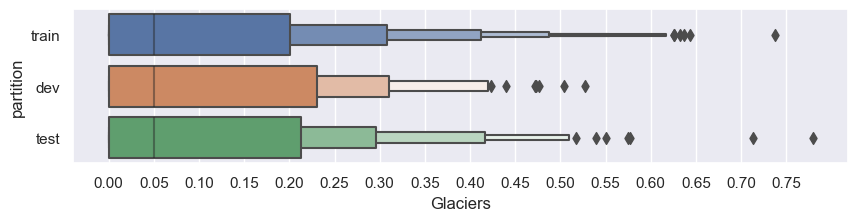

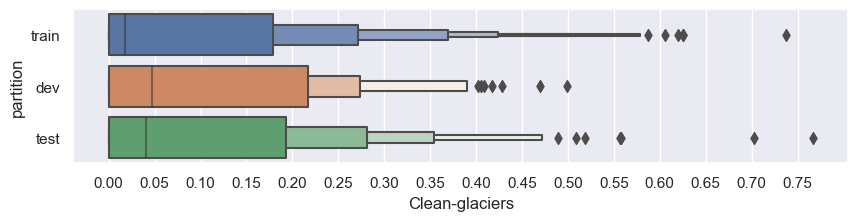

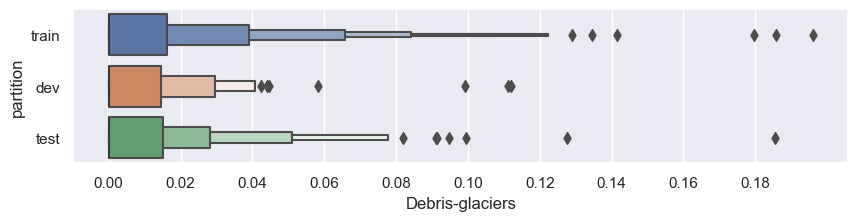

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
sns.set(rc={"figure.figsize":(10, 2)})

sns.boxenplot(data=metadata, x='glaciers', y='partition')
plt.xticks(np.arange(0,metadata.glaciers.max(), .05))
plt.xlabel('Glaciers')
plt.show()

sns.boxenplot(data=metadata, x='clean_glaciers', y='partition')
plt.xticks(np.arange(0,metadata.clean_glaciers.max(), .05))
plt.xlabel('Clean-glaciers')
plt.show()

sns.boxenplot(data=metadata, x='debris_glaciers', y='partition')
plt.xticks(np.arange(0,metadata.debris_glaciers.max(), .02))
plt.xlabel('Debris-glaciers')
plt.show()

### Creating Label for images based on our threshold value of 0.2 and Masks of the image.

> Those images with pixels less than 20% are identified as non-glacier image and more than 20% as glacier image

In [31]:
THRESHOLD = 0.05
metadata.loc[metadata.glaciers>THRESHOLD,'label'] = 1
metadata.label.fillna(0, inplace=True)
metadata.head()

img_slice  \
src slice_num                                                
0   003        og_dataset/splits/train/slice_0_img_003.npy   
    004        og_dataset/splits/train/slice_0_img_004.npy   
    015        og_dataset/splits/train/slice_0_img_015.npy   
    030        og_dataset/splits/train/slice_0_img_030.npy   
    039        og_dataset/splits/train/slice_0_img_039.npy   

                                                 mask_slice  glaciers  \
src slice_num                                                           
0   003        og_dataset/splits/train/slice_0_mask_003.npy       0.0   
    004        og_dataset/splits/train/slice_0_mask_004.npy       0.0   
    015        og_dataset/splits/train/slice_0_mask_015.npy       0.0   
    030        og_dataset/splits/train/slice_0_mask_030.npy       0.0   
    039        og_dataset/splits/train/slice_0_mask_039.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   003                   0.0              0.0  189.766983  379341.754386   
    004                   0.0              0.0  198.229507  394523.684211   
    015                   0.0              0.0   79.945312  333795.964912   
    030                   0.0              0.0   59.981003  333795.964912   
    039                   0.0              0.0  254.508530  470433.333333   

                        lat partition  label  
src slice_num                                 
0   003        3.572176e+06     train    NaN  
    004        3.572176e+06     train    NaN  
    015        3.587358e+06     train    NaN  
    030        3.602540e+06     train    NaN  
    039        3.602540e+06     train    NaN

In [19]:
metadata.to_csv('dataset/metadata.csv')

## Normalise data
Since some of the slices were added to the group by us, only the old slices are normalised, while the new ones are unnormalized.

We start by loading the statistics that were used to normalize the old slices. This is a JSON file containing the estimated mean and std deviation for each channel.

In [69]:
with open(normalization_file) as f:
    nf = json.load(f)
metadata = pd.read_csv('dataset/metadata.csv', index_col=['src','slice_num'])
new_images = metadata[metadata.label == 0]

In [5]:
norm_sample = np.load(metadata.loc[3,56].img_slice)
unnorm_sample = np.load(metadata.loc[3,65].img_slice)

np.nansum(norm_sample) % 1

0.625

In [24]:
from tqdm import tqdm

a = 0

for idx, row in tqdm(metadata.iterrows()):
    img = np.load(row.img_slice)
    m = np.nansum(img[:,:,:3])
    if m % 1 == 0:
        a += 1

a

1096it [00:37, 29.18it/s]


548

In [6]:
metadata

img_slice  \
src slice_num                                                 
0   3           og_dataset/splits/train/slice_0_img_003.npy   
    4           og_dataset/splits/train/slice_0_img_004.npy   
    15          og_dataset/splits/train/slice_0_img_015.npy   
    30          og_dataset/splits/train/slice_0_img_030.npy   
    39          og_dataset/splits/train/slice_0_img_039.npy   
...                                                     ...   
34  166        og_dataset/splits/train/slice_34_img_166.npy   
    178        og_dataset/splits/train/slice_34_img_178.npy   
    180        og_dataset/splits/train/slice_34_img_180.npy   
    189        og_dataset/splits/train/slice_34_img_189.npy   
    190         og_dataset/splits/test/slice_34_img_190.npy   

                                                  mask_slice  glaciers  \
src slice_num                                                            
0   3           og_dataset/splits/train/slice_0_mask_003.npy       0.0   
    4           og_dataset/splits/train/slice_0_mask_004.npy       0.0   
    15          og_dataset/splits/train/slice_0_mask_015.npy       0.0   
    30          og_dataset/splits/train/slice_0_mask_030.npy       0.0   
    39          og_dataset/splits/train/slice_0_mask_039.npy       0.0   
...                                                      ...       ...   
34  166        og_dataset/splits/train/slice_34_mask_166.npy       0.0   
    178        og_dataset/splits/train/slice_34_mask_178.npy       0.0   
    180        og_dataset/splits/train/slice_34_mask_180.npy       0.0   
    189        og_dataset/splits/train/slice_34_mask_189.npy       0.0   
    190         og_dataset/splits/test/slice_34_mask_190.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   3                     0.0              0.0  189.766983  379341.754386   
    4                     0.0              0.0  198.229507  394523.684211   
    15                    0.0              0.0   79.945312  333795.964912   
    30                    0.0              0.0   59.981003  333795.964912   
    39                    0.0              0.0  254.508530  470433.333333   
...                       ...              ...         ...            ...   
34  166                   0.0              0.0  103.992096  689057.960603   
    178                   0.0              0.0   38.783714  871241.645430   
    180                   0.0              0.0    7.044047  673875.986868   
    189                   0.0              0.0   97.482529  810513.750488   
    190                   0.0              0.0   98.216232  825695.724223   

                        lat partition  label  
src slice_num                                 
0   3          3.572176e+06     train    0.0  
    4          3.572176e+06     train    0.0  
    15         3.587358e+06     train    0.0  
    30         3.602540e+06     train    0.0  
    39         3.602540e+06     train    0.0  
...                     ...       ...    ...  
34  166        3.108040e+06     train    0.0  
    178        3.108040e+06     train    0.0  
    180        3.123222e+06     train    0.0  
    189        3.123222e+06     train    0.0  
    190        3.123222e+06      test    0.0  

[1096 rows x 10 columns]

In [70]:
from sklearn.base import BaseEstimator, TransformerMixin

class Custom_Normalizer (BaseEstimator, TransformerMixin):
    def __init__ (self, means, std, path = 'og_dataset/splits/normalized/'):
        self.path = path
        self.means = means
        self.std = std
        
    def transform (self, X, y=None):
        X = X.copy()
        os.makedirs(self.path, exist_ok= True)
        for idx, row in X.iterrows():
            img = np.load(row.img_slice)
            if not self.is_norm(img):
                img = (img - self.means)/self.std
                new_path = self.path + f'slice_{idx[0]}_img_{idx[1]}.npy'
                X.loc[idx,'img_slice'] = new_path
                np.save(new_path, img )
                
        return X
              
    def is_norm (self, img):
        return np.nansum(img) % 1 != 0
        
        

In [71]:
metadata_norm = Custom_Normalizer(nf['means'],nf['stds']).transform(metadata)

In [72]:
metadata_norm

img_slice  \
src slice_num                                                      
0   3             og_dataset/splits/normalized/slice_0_img_3.npy   
    4             og_dataset/splits/normalized/slice_0_img_4.npy   
    15           og_dataset/splits/normalized/slice_0_img_15.npy   
    30           og_dataset/splits/normalized/slice_0_img_30.npy   
    39           og_dataset/splits/normalized/slice_0_img_39.npy   
...                                                          ...   
34  166        og_dataset/splits/normalized/slice_34_img_166.npy   
    178        og_dataset/splits/normalized/slice_34_img_178.npy   
    180        og_dataset/splits/normalized/slice_34_img_180.npy   
    189        og_dataset/splits/normalized/slice_34_img_189.npy   
    190        og_dataset/splits/normalized/slice_34_img_190.npy   

                                                  mask_slice  glaciers  \
src slice_num                                                            
0   3           og_dataset/splits/train/slice_0_mask_003.npy       0.0   
    4           og_dataset/splits/train/slice_0_mask_004.npy       0.0   
    15          og_dataset/splits/train/slice_0_mask_015.npy       0.0   
    30          og_dataset/splits/train/slice_0_mask_030.npy       0.0   
    39          og_dataset/splits/train/slice_0_mask_039.npy       0.0   
...                                                      ...       ...   
34  166        og_dataset/splits/train/slice_34_mask_166.npy       0.0   
    178        og_dataset/splits/train/slice_34_mask_178.npy       0.0   
    180        og_dataset/splits/train/slice_34_mask_180.npy       0.0   
    189        og_dataset/splits/train/slice_34_mask_189.npy       0.0   
    190         og_dataset/splits/test/slice_34_mask_190.npy       0.0   

               clean_glaciers  debris_glaciers    img_mean            lng  \
src slice_num                                                               
0   3                     0.0              0.0  189.766983  379341.754386   
    4                     0.0              0.0  198.229507  394523.684211   
    15                    0.0              0.0   79.945312  333795.964912   
    30                    0.0              0.0   59.981003  333795.964912   
    39                    0.0              0.0  254.508530  470433.333333   
...                       ...              ...         ...            ...   
34  166                   0.0              0.0  103.992096  689057.960603   
    178                   0.0              0.0   38.783714  871241.645430   
    180                   0.0              0.0    7.044047  673875.986868   
    189                   0.0              0.0   97.482529  810513.750488   
    190                   0.0              0.0   98.216232  825695.724223   

                        lat partition  label  
src slice_num                                 
0   3          3.572176e+06     train    0.0  
    4          3.572176e+06     train    0.0  
    15         3.587358e+06     train    0.0  
    30         3.602540e+06     train    0.0  
    39         3.602540e+06     train    0.0  
...                     ...       ...    ...  
34  166        3.108040e+06     train    0.0  
    178        3.108040e+06     train    0.0  
    180        3.123222e+06     train    0.0  
    189        3.123222e+06     train    0.0  
    190        3.123222e+06      test    0.0  

[1096 rows x 10 columns]

## Distributions of features and binning
We now want to get a feel of what's the distribution of values of the 15 channels:
1. LE7 B1 (blue)
2. LE7 B2 (green)
3. LE7 B3 (red)
4. LE7 B4 (near infrared)
5. LE7 B5 (shortwave infrared 1)
6. LE7 B6_VCID_1 (low-gain thermal infrared)
7. LE7 B6_VCID_2 (high-gain thermal infrared)
8. LE7 B7 (shortwave infrared 2)
9. LE7 B8 (panchromatic)
10. LE7 BQA (quality bitmask)
11. NDVI (vegetation index)
12. NDSI (snow index)
13. NDWI (water index)
14. SRTM 90 elevation
15. SRTM 90 slope

In [10]:
np.histogram(np.load(test_folder + 'slice_10_img_174.npy')[:,:,2], density=True)
# np.load(train_folder + 'slice_1_img_150.npy')
# https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

(array([0.25991968, 0.52085916, 0.25687425, 0.17556859, 0.17742167,
        0.18223393, 0.19781991, 0.23406269, 0.26239046, 1.49853848]),
 array([-1.4382831 , -1.1727275 , -0.9071718 , -0.6416161 , -0.37606046,
        -0.11050481,  0.15505084,  0.4206065 ,  0.6861622 ,  0.9517178 ,
         1.2172735 ], dtype=float32))

Load the images from the _dev set_ to memory to perform analysis on the distribution of values. We pick only those in _dev set_ due to memory limitations

In [11]:
metadata.loc[metadata.partition=='dev','features'] = metadata[metadata.partition=='dev'].img_slice.apply(lambda x: np.load(x))
dev_data = metadata[metadata.partition=='dev']

dev_data.features.iloc[0][:,:,1]

array([[49., 49., 48., ..., 68., 60., 59.],
       [49., 48., 48., ..., 79., 64., 65.],
       [49., 46., 47., ..., 68., 64., 67.],
       ...,
       [69., 69., 67., ..., 62., 61., 60.],
       [67., 70., 69., ..., 62., 62., 64.],
       [67., 68., 67., ..., 63., 62., 60.]], dtype=float32)

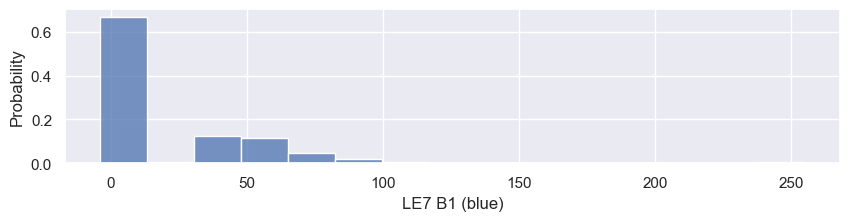

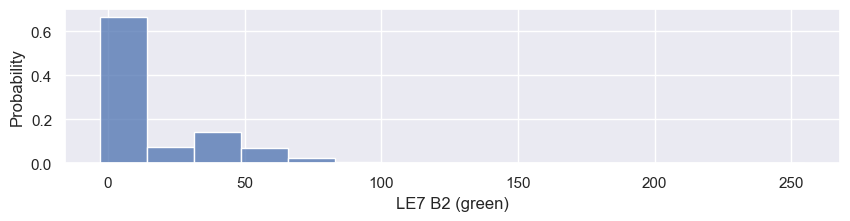

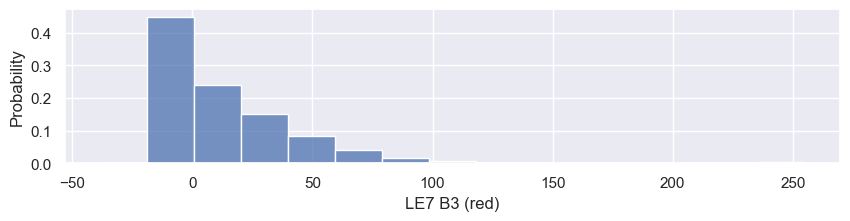

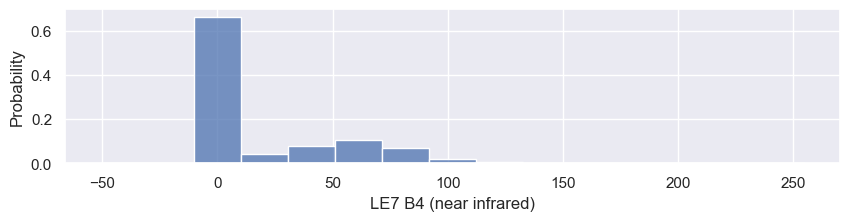

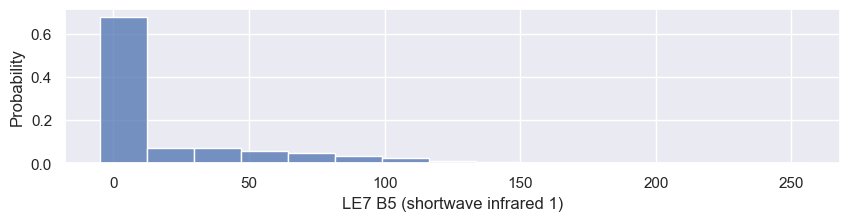

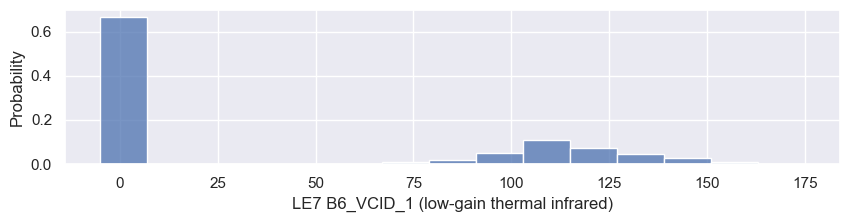

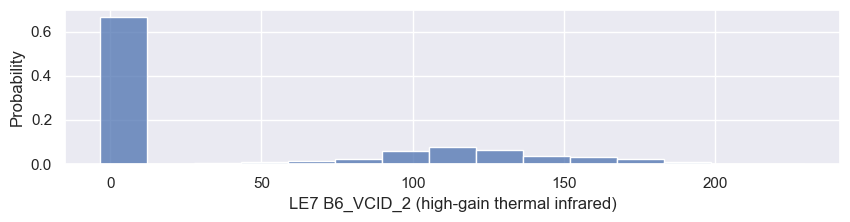

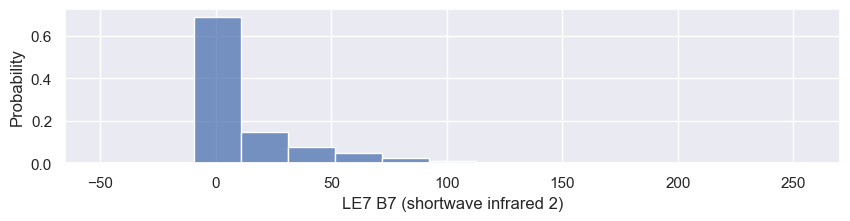

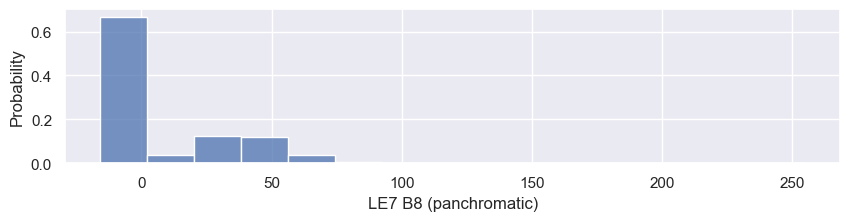

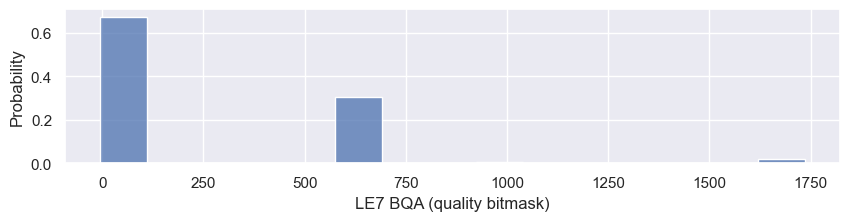

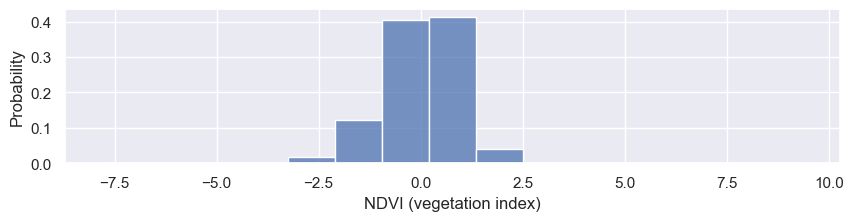

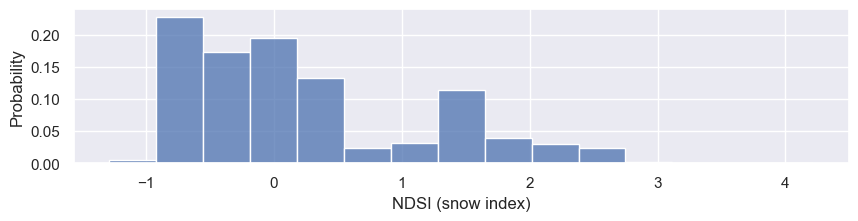

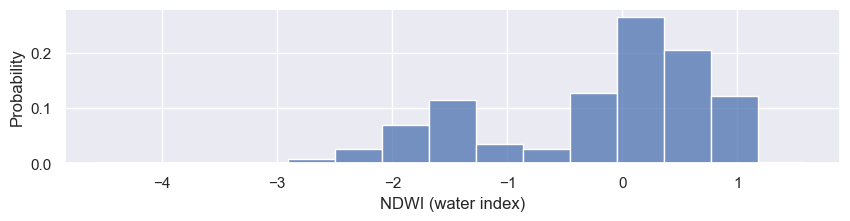

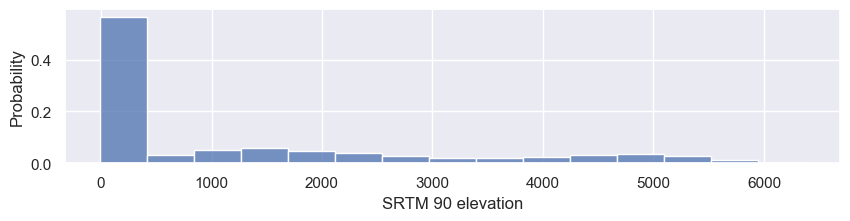

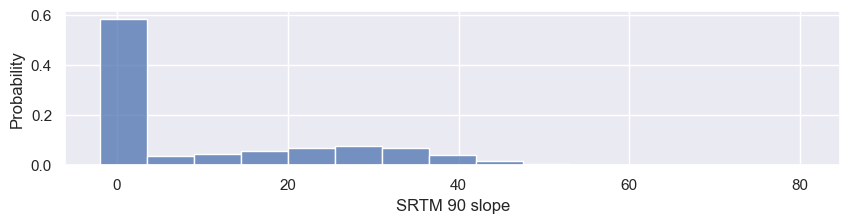

In [15]:
descr = pd.DataFrame() 

feature_names = ['LE7 B1 (blue)', 'LE7 B2 (green)', 'LE7 B3 (red)', 'LE7 B4 (near infrared)', 'LE7 B5 (shortwave infrared 1)', 'LE7 B6_VCID_1 (low-gain thermal infrared)', 'LE7 B6_VCID_2 (high-gain thermal infrared)', 'LE7 B7 (shortwave infrared 2)', 'LE7 B8 (panchromatic)', 'LE7 BQA (quality bitmask)', 'NDVI (vegetation index)', 'NDSI (snow index)', 'NDWI (water index)', 'SRTM 90 elevation', 'SRTM 90 slope']
for i,name in enumerate(feature_names):
    d_i = dev_data.features.apply(lambda m: m[:,:,i].flat).agg(np.concatenate)
    d_i = d_i[np.logical_not(np.isnan(d_i))]
    p01 = np.percentile(d_i, 1e-4)
    p99 = np.percentile(d_i, 1 - 1e-4)
    # print(p01, p99)
    # d_i = d_i[(d_i>=-10) & (d_i<=10)]
    
    descr = pd.concat([
        descr, 
        pd.Series(d_i, name=name).agg([min, 'median', 'mean', max])
    ], axis=1)
    
    sns.histplot(x=d_i, stat='probability', bins=15)
    del d_i
    plt.xlabel(name)
    plt.show()

In [16]:
BIN_SIZE = 0.5

descr = descr.transpose()
descr['layer'] = range(0,15)
descr['bins'] = descr.apply(lambda x: np.arange(x['min'], x['max'], BIN_SIZE), axis=1)
descr

,min,median,mean,max,layer,bins
LE7 B1 (blue),-3.703597,1.199606,20.041895,255.000000,0,"[-3.703596830368042, -3.203596830368042, -2.70..."
LE7 B2 (green),-2.695384,1.038356,16.101662,255.000000,1,"[-2.6953837871551514, -2.1953837871551514, -1...."
LE7 B3 (red),-38.299278,1.217273,16.033924,255.000000,2,"[-38.299278259277344, -37.799278259277344, -37..."
LE7 B4 (near infrared),-50.749935,0.774132,20.621222,255.000000,3,"[-50.749935150146484, -50.249935150146484, -49..."
LE7 B5 (shortwave infrared 1),-4.818408,0.374204,18.544310,255.000000,4,"[-4.818408012390137, -4.318408012390137, -3.81..."
LE7 B6_VCID_1 (low-gain thermal infrared),-4.969496,0.312299,38.371895,175.021744,5,"[-4.969496250152588, -4.469496250152588, -3.96..."
LE7 B6_VCID_2 (high-gain thermal infrared),-3.261882,0.724698,40.756729,229.717392,6,"[-3.2618818283081055, -2.7618818283081055, -2...."
LE7 B7 (shortwave infrared 2),-49.940845,0.431811,13.064932,255.000000,7,"[-49.94084548950195, -49.44084548950195, -48.9..."
LE7 B8 (panchromatic),-15.770833,0.870554,14.106095,255.000000,8,"[-15.770833015441895, -15.270833015441895, -14..."
LE7 BQA (quality bitmask),-4.531066,0.853833,237.434113,1736.000000,9,"[-4.531065940856934, -4.031065940856934, -3.53..."
